# Maximum Likelihood Estimation

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 
from cs349 import *

**Context:** At this point, our modeling toolkit is already getting quite expressive. 
1. We can develop simple *predictive models* using *conditional distributions*: we can specify models of the form $p_{A | B}(a | b)$, which allow us to predict the probability that $A = a$ given that $B = b$. We do this by specifying a distribution over random variable (RV) $A$, whose parameters are a *function* of $b$.  
2. We can develop simple *generative models* using *joint distributions*: we can specify models of the form $p_{A, B}(a, b)$, which allow us to sample (or generate) data. We do this by factorizing this joint probability into a product of conditional and marginal distributions, e.g. $p_{A, B}(a, b) = p_{A | B}(a | b) \cdot p_B(b)$, which we already know how to specify.

Of course, the predictive and generative models you may have heard about in the news are capable of doing more than the instances we've covert so far---we will build up to these fancy models over the course of the semester. What's important for now, though, is that you understand how such models can be represented using probability distributions. 

**Challenge:** So what stands in our way of applying our modeling tools to real-world data? First, we've only instantiated our models with *discrete* distributions. Many real-world data, however, requires *continuous* distributions; that is, distributions over real numbers (e.g. blood pressure, body-mass index, time spent in REM sleep, etc.). We'll get more into the details of continuous modeling a bit later. Our second obstacle is: we still don't have a way of *automatically* fitting a model to data. So far, you've fit all models to data by hand via inspection---you looked at the data and tried to match the model to the data. With increasing model and data complexity, it becomes prohibitively difficult to fit the model to the data by hand. Today, we'll introduce one technique for doing this: maximum likelihood estimation (MLE). This is the first algorithm that truly allows the "machine to learn."

The idea behind MLE is to find a model under which the probability of the data is highest. The intuition behind the MLE is that a model that scores the observed data as likely could have reasonably generated the data.

**Outline:**
* Formally introduce and motivate the MLE.
* Extend notation of directed graphical models to represent a full data-set instead of just one observation.
* Implement MLE in `NumPyro`.

Let's load our IHH ER data again so we remember what we're working with:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of 5 patients, just to see what's in the data
data.sample(15, random_state=0)

,Day-of-Week,Condition,Hospitalized,Antibiotics,Attempts-to-Disentangle
Patient ID,,,,,
9394,Friday,Allergic Reaction,No,No,NaN
898,Sunday,Allergic Reaction,Yes,Yes,NaN
2398,Saturday,Entangled Antennas,No,No,4.0
5906,Saturday,Allergic Reaction,No,No,NaN
2343,Monday,High Fever,Yes,No,NaN
8225,Thursday,High Fever,Yes,No,NaN
5506,Tuesday,High Fever,No,No,NaN
6451,Thursday,Allergic Reaction,No,No,NaN
2670,Sunday,Intoxication,No,No,NaN


## MLE: Notation and Formalism

The idea behind the MLE is to find the model parameters that maximize the probability of the data. Let's introduce some notation to help us formalize what this means mathematically.

**Notation for Data.** Let $\mathcal{D}$ denote our *all* of our observed data ($\mathcal{D}$ represents the entirety of the above table). Let $\mathcal{D}_n$ represent observation number $n$ (i.e. row $n$) from the table. $\mathcal{D}_n$ is a tuple of values at each of the columns: $\mathcal{D}_n = (d_n, c_n, h_n, a_n, m_n)$. Recall that we define:
* $D$: Day-of-Week	
* $C$: Condition	
* $H$: Hospitalized	
* $A$: Antibiotics
* $M$: Attempts-to-Disentangle

**Notation for Parameters.** For simplicity, we've omitted the notation for each distribution's parameters from the notation so far. From now on, we'll explicitly write out the parameters as arguments to the distribution by listing them after a semi-colon. 
> For example, we can denote that a joint distribution over RVs $A$ and $B$ depends on a parameter $\theta$ as follows: $p_{A, B}(a, b; \theta)$. Similarly, we can write a conditional that depends on $\theta$ using $p_{A | B}(A | B; \theta)$.
>
> If different components of the distribution depend on different parameters, we can list them. For example, in a joint distribution over $A$ and $B$, we can have the conditional depend on $\theta$ and the marginal depend on $\phi$: $p_{A, B}(a, b; \theta, \phi) = p_{A | B}(a | b; \theta) \cdot p_B(b; \phi)$. 

**The MLE Objective.**
Let $\theta$ denote the set of all parameters used in our model for the IHH ER data. Using the above notation, $p_{D, C, H, A, M}(\mathcal{D}; \theta)$ denotes the probability of the observed data. Our goal is then to find the parameters $\theta$ that maximize the probability of having observed $\mathcal{D}$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}; \theta),
\end{align}
wherein "argmax" denotes the value of $\theta$ that maximizes the joint probability. So what does it mean to evaluate the probability of the *whole data*, $\mathcal{D}$, under our model, $p_{D, C, H, A, M}$? It means evaluating the *joint distribution of all observations*, $\mathcal{D}_n = (d_n, c_n, h_n, a_n, m_n)$ for every $n \in [1, N]$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta),
\end{align}
where $N$ is the total number of observations. 

Now, recall that every joint distribution can be factorized into a product of conditional and marginal distributions, and that the number of possible factorizations grows unwieldy very quickly with the number of variables. Since the number of variables in this joint distribution is a function of the number of observations, $N$, which is large (e.g. thousands), we need some way to select a reasonable factorization. As typical, we are going to assume that the observations are independent, and identically distributed (i.i.d). This means that one patient coming to the ER does not tell us anything about how likely other patients are to come to the ER. Now, recall that when two RVs are independent, their joint distribution equals a product of their marginals. We can therefore factorize the joint distribution as follows:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1; \theta) \cdot p(\mathcal{D}_2; \theta) \cdots p(\mathcal{D}_N; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N \underbrace{p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)}_{\text{We already know how to compute this!}}
\end{align}
We have now arrived at a formula for the joint distribution that we know how to compute---we've even written code to evaluate it in `NumPyro`.

**Numerical Stability:** Notice that since our joint is a discrete probability distribution, it outputs probabilities between 0 and 1: $p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) \in [0, 1]$. In other words, it outputs *fractions*. In the above formula, we then multiply these fractions times one another $N$ times. But what happens when you multiply fractions together many times? Answer: the results shrinks towards 0 very quickly (try it yourself!). This is a problem, because our computer can only represent small numbers up to a finite precision. For a large $N$, our computer will round down the answer to $0$, which will prevent us from performing the argmax. Because of this issue, we have to transform our original MLE objective into a problem that a computer can numerically solve. 

We do this by maximizing the $\log$ of the joint probability for two reasons:
1. Logs turn products into sums: $\log X \cdot Y = \log X + \log Y$. Applying this formula to our MLE objective results in a *sum* of fractions, which is numerically stable:
\begin{align}
\log \prod\limits_{n=1}^N p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) = \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)
\end{align}
2. But by maximizing the $\log$ of the joint probability instead, will we get the wrong answer? Because the $\log$ function is a *strictly increasing function*, our maxima will remain in the same location. That is:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \prod\limits_{n=1}^N p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) \\
&= \mathrm{argmax}_{\theta} \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)
\end{align}
To illustrate point (2), check out the graph below, which shows that the argmax of a function doesn't change if a $\log$ is applied to it.

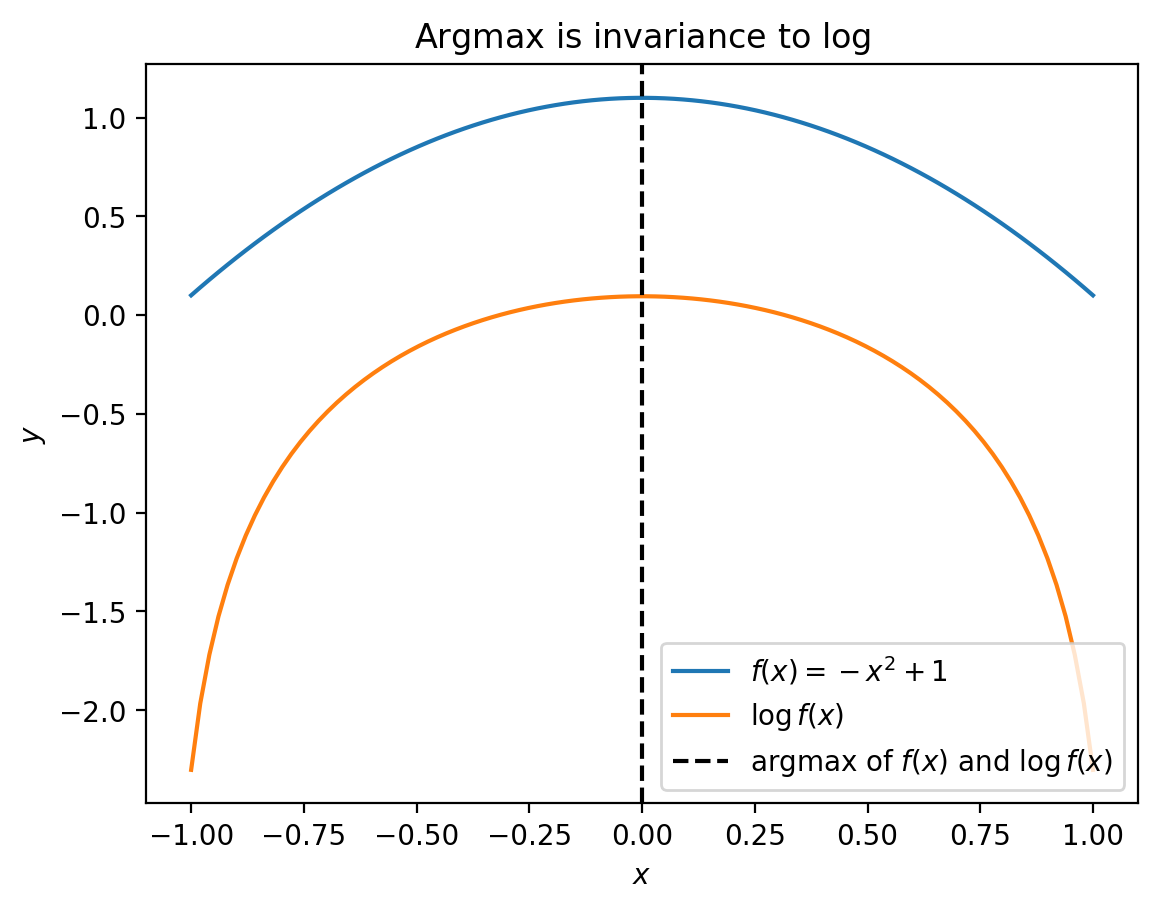

In [3]:
plot_invariance_of_argmax_under_log()

**Optimization:** So at this point, we can compute the MLE objective for specific choices of $\theta$, but we don't know yet how to perform the argmax operation. We'll introduce this concept a bit later in the course. For now, we'll provide you with a function that can perform the maximization.

## Graphically Representing I.I.D Observations and Model Parameters 

Before implementing the MLE in `NumPyro`, we will extend our Directed Graphical Model representation (DGM) to include i.i.d observations and model parameters. This will help us in the translation process from math to code. Suppose we have a simple joint distribution over two RVs, $A$ and $B$, whose conditional controlled by a parameter, $\theta$, as follows:
\begin{align}
p_{A, B}(a, b; \theta) &= p_{B | A}(b | a; \theta) \cdot p_A(a)
\end{align}
Suppose further that we have $N$ i.i.d observations from this joint distribution. That is, we have $\mathcal{D}_n = (a_n, b_n)$ for $n \in [1, N]$. This gives us the following joint distribution over the entire data:
\begin{align}
p(\mathcal{D}; \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \quad \text{since the observations are i.i.d} \\
&= \prod\limits_{n=1}^N p_{A, B}(a_n, b_n; \theta) \\
&= \prod\limits_{n=1}^N p_{B | A}(b_n | a_n; \theta) \cdot p_A(a_n)
\end{align}
How would we represent this graphically? The answer is a little messy:
<img align="center" width="500px" src="figs/mle-plate-and-parameter-example-bad.png" />

Each pair $(A_n, B_n)$ get its own arrow to signify the conditional dependence of $B_n$ on $A_n$. And since every pair depends on the same parameter, $\theta$ has an arrow pointing into every $B_n$. 

**Representing Parameters.** In the above, notice that circles are only used for RVs. Since $\theta$ is not an RV, it is not inside a circle---it's represented by a dot instead.

**Representing I.I.D Observations:** For more complicated models, like the IHH ER you've already developed, this graphical representation becomes too difficult to read. As a result, we use the following short-hand:
<img align="center" width="500px" src="figs/mle-plate-and-parameter-example-good.png" />

In this representation, we introduce a "plate" (the rectangle surrounding $A_n$ and $B_n$). The plate denotes that what's inside should be repeated $N$ times, where $N$ is written in the bottom-right corner. Why is this called a plate? Do you eat off of rectangular plates at home? This shall remain a mystery to us all...

**A note on conditional independence:** We note that in this example model, for the IHH ER model you've developed, and generally for the models we consider in this class, the observations are only i.i.d given the model parameters. That is, given $\theta$, we can factorize $p(\mathcal{D}; \theta)$ into $\prod_{n=1}^N p(\mathcal{D}_n; \theta)$. However, if we do not "condition" on the parameters, $\theta$, the observations do carry knowledge about one another. That is, having observed $\mathcal{D}_1$ can tell me something about $\mathcal{D}_2$ because it tells me something about $\theta$, which is shared across all observations. More on that later in the course.

````{admonition} Exercise
**Part 1:** Extend the graphical model for the IHH ER below to represent the entirety of the data. Additionally, include all parameters of all distributions.

<img align="center" width="500px" src="figs/joint-probability-ihh-er-dgm.png" />

**Part 2:** TODO translate more between equations and DGMs!

````

## MLE in `NumPyro`

We're now ready to translate our model into `NumPyro` code that we can then use to fit to data. To do this, we will rely on three `NumPyro` primitives to code the joint distribution of the whole data:
* `numpyro.param`, which represents model parameters
* `numpyro.sample`, which represents an RV
* `numpyro.plate`, which represents i.i.d sampling using the "plate" notation

We'll walk you through how to use these primitives to build the model, but we additionally recommend you get in the habit of reading the [relevant documentation](https://num.pyro.ai/en/stable/primitives.html).

**Concept:** In `NumPyro`, models are implemented as Python functions, which use the above primitives to sample from the joint distribution. We do this by factorizing the joint distribution and sampling from its components in some valid ordering. This will suffice in providing `NumPyro` with enough information to do the heavy lifting of the MLE. 

**Example:** We'll illustrate how to do this using an example. Suppose we want to model the joint distribution of the day-of-the-week, $D$, and whether a patient is intorixated, $I$. We can do this via the model,
\begin{align}
p(\mathcal{D}; \pi, \rho) &= \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi).
\end{align}
In this model,
* *Marginal:* $p_D(\cdot; \pi)$ is a distribution over the days of the week. We will therefore define it to be a Categorical distribution:
\begin{align}
p_D(\cdot; \pi) = \mathrm{Cat}(\pi).
\end{align} Here, the parameter $\pi$ is a 7-dimensional array describing the probability of an observation coming from each of the 7 days of the week. That is, the probability of $D = d_n$ is given by the $d_n$-th entry of $\pi$: i.e. $p_{D}(d_n; \pi) = \pi_{d_n}$.
* *Conditional:* $p_{I | D}(\cdot | d_n; \rho)$ is the probability that a patient arrives at the ER with intoxication given that $D = d_n$. Since "intoxication" is a binary outcome, we will model it using a Bernoulli. However, recall that the probability of intoxication *changes with the day of the week*---on some days, we're more likely to treat patients with intoxication. The parameter of the Bernoulli distribution therefore needs to change depending on the day of the week. We therefore define:
\begin{align}
p_{I | D}(i_n | d_n; \rho) = \mathrm{Ber}(\rho_{d_n}).
\end{align} By this, we mean that $\rho$ is a 7-dimensional vector, where the $d_n$-th entry, denoted by $\rho_{d_n}$, is the probability of intoxication on day $d_n$. 

**Valid Parameter Values:** Since each entry of $\rho$ represents a Bernoulli distribution, each entry must be on between 0 and 1 (i.e. on the "unit interval"). And since $\pi$ is represents a Categorical distribution, its entries must sum to 1 (a fancy name of this is that $\pi$ lies on a "simplex"). We note this briefly because we will have to communicate to `NumPyro` the valid values these parameters may take on (but don't worry, this isn't hard to do).

**Generative Process:** For this model, we assume the data was sampled (or generated) as follows:
* *Step 1:* We choose an initial guess for $\pi$ and $\rho$. Our guess doesn't need to be good, since `NumPyro` help us find the right values.
* *Step 2:* For every $n \in [1, N]$:
  * *Step 2a:* We sample $d_n$ from the marginal, $d_n \sim p_D(\cdot; \pi) = \mathrm{Cat}(\pi)$. 
  * *Step 2b:* Given the specific value of $d_n$ from Step 2a, we sample from the conditional, $i_n | d_n \sim p_{I | D}(\cdot | d_n; \rho) = \mathrm{Ber}(\rho_{d_n})$.

**Code:** Now that we have our generative process spelled out, let's translate it directly into code.
We start by creating a function to represent our model:
```
def model_of_intoxication_given_day(N, d=None, i=None):
    pass
```
This function takes in several arguments:
* The total number of observations, $N$.
* Optional arrays describing the observations. That is, `d` represents an array of all $N$ days of the week, and `i` represents all $N$ binary values intoxication-yes/no. When sampling data from the model, we do not pass in `d` and `i`, but when performing the MLE, we do need to pass them in. This is because the MLE objective will try to find settings of $\pi, \rho$ that will make our observed data most likely.

Next, we can go through each step of the generative process above and translate it into `NumPyro`, line by line:
* *Step 1:* We define our parameters using the `numpyro.param` primitive.
```
pi = numpyro.param(
    'pi',                          # A name used by NumPyro
    init_value=jnp.ones(7) / 7.0,  # Initial value for pi: [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]
    constraint=C.simplex,          # Entries of pi must sum to 1 (i.e. lie on a "simplex")
)

rho = numpyro.param(
    'rho',                         # A name used by NumPyro
    init_value=jnp.ones(7) * 0.5,  # Initial value for rho: [0.5, 0.5, 0.5, 0.5, 0.5. 0.5, 0.5]
    constraint=C.unit_interval,    # Each entry of rho must be in [0, 1] (i.e. lie in "unit interval")
)
```
You can find more types of constraints listed [here](https://num.pyro.ai/en/stable/_modules/numpyro/distributions/constraints.html).
* *Step 2:* We create a "plate" to indicate $N$ i.i.d observations using `numpyro.plate`.
```
with numpyro.plate('data', N):
    pass
```
  * *Step 2a:* Inside the plate, we sample $d_n$ from the marginal, $d_n \sim p_D(\cdot; \pi) = \mathrm{Cat}(\pi)$, using `numpyro.sample`.
```
# Define marginal as Categorical using pi
p_D = D.Categorical(pi)

# Sample from the marginal
d = numpyro.sample('d', p_D, obs=d)  
```
  * *Step 2b:* Inside the plate, we use the specific value of $d_n$ from Step 2a to sample from the conditional, $i_n | d_n \sim p_{I | D}(\cdot | d_n; \rho) = \mathrm{Ber}(\rho_{d_n})$ using `numpyro.sample`.
```
# Define conditional as Bernoulli. Notice rho[d] to access the d-th entry of rho
p_I_given_D = D.Bernoulli(rho[d])

# Sample from the conditional 
i = numpyro.sample('i', p_I_given_D, obs=i)
```

Putting everything together, we arrive at the following code:

In [4]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C


def model_of_intoxication_given_day(N, d=None, i=None):
    pi = numpyro.param(
        'pi', 
        init_value=jnp.ones(7) / 7.0, 
        constraint=C.simplex,
    )
    
    rho = numpyro.param(
        'rho', 
        init_value=jnp.ones(7) * 0.5, 
        constraint=C.unit_interval,
    )
    
    with numpyro.plate('data', N):
        p_D = D.Categorical(pi)
        d = numpyro.sample('d', p_D, obs=d)

        p_I_given_D = D.Bernoulli(rho[d])
        i = numpyro.sample('i', p_I_given_D, obs=i)

Let's check to see if we coded the model correctly by asking `NumPyro` to visualize the directed graphical model for us:

In [14]:
N = len(data)

numpyro.render_model(
    model_of_intoxication_given_day, 
    model_args=(N,), 
    render_distributions=True, 
    render_params=True,
)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

**Sampling from the Model:** We created a helper function for you in order to sample from this model. Note that we haven't fit the model yet to the data.

In [6]:
N = 20 # Number of samples to generate
key = jrandom.PRNGKey(seed=0) # Random generator key to use
cs349_sample(model_of_intoxication_given_day, key, N)

{'pi': Array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
        0.14285715, 0.14285715], dtype=float32),
 'rho': Array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32),
 'd': Array([4, 2, 4, 5, 6, 4, 4, 5, 3, 1, 5, 2, 2, 2, 5, 0, 2, 0, 0, 5], dtype=int32),
 'i': Array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int32)}

**Performing the MLE:** We will now perform the MLE using another helper function we've created. Recall that the MLE for this model is:
\begin{align}
\pi^\text{MLE}, \rho^\text{MLE} &= \mathrm{argmax}_{\pi, \rho} \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi) \\
&= \mathrm{argmax}_{\pi, \rho} \log \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi) \\
&= \mathrm{argmax}_{\pi, \rho} \sum\limits_{n=1}^N \log p_{I | D}(i_n | d_n; \rho) + \log p_D(d_n; \pi)
\end{align}

In [7]:
# Get data from the data frame. 
# Use our helper function, convert_day_of_week_to_int, to convert the days of the week to ints
d = jnp.array(convert_day_of_week_to_int(data['Day-of-Week']).values)
i = jnp.array((data['Condition'] == 'Intoxication').astype(int).values)

N = len(d)
NUM_STEPS = 1000
result = cs349_mle(
    model_of_intoxication_given_day, 
    jrandom.PRNGKey(0),
    NUM_STEPS,
    N, 
    d=d, 
    i=i,
    learning_rate=0.01
)

100%|█| 1000/1000 [00:01<00:00, 671.37it/s, init loss: 26390.5742, avg. loss [951-1000]:


**Visualizing the Convergence of the MLE:** We can plot the model's log-likelihood with each iteration of the optimizer to see whether (1) the log-likelihood is increasing, as it should, and (2) whether the optimization converged (i.e. do we think there's no more room to improve).

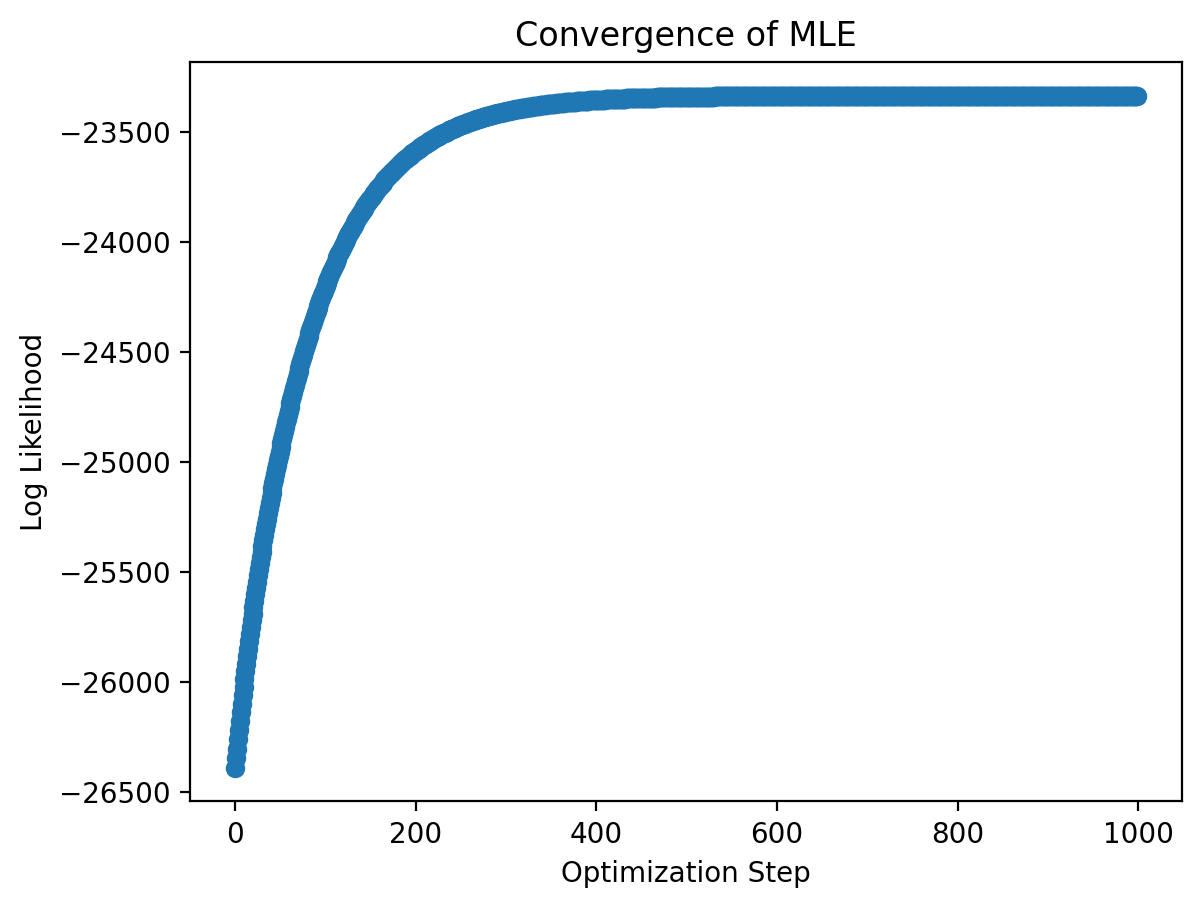

In [8]:
plt.scatter(jnp.arange(NUM_STEPS), result.log_likelihood)
plt.xlabel('Optimization Step')
plt.ylabel('Log Likelihood')
plt.title('Convergence of MLE')
plt.show()

**Visualizing the Model's Parameters:** The learned model's parameters can be accessed as below.

In [9]:
result.parameters_mle

{'pi': Array([0.19870001, 0.1529    , 0.13990001, 0.1419    , 0.136     ,
        0.113     , 0.11760001], dtype=float32),
 'rho': Array([0.09473917, 0.09301588, 0.09448019, 0.10785804, 0.10519359,
        0.40796468, 0.41496596], dtype=float32)}

We can then visualize these learned probabilities to see if they match our observed data.

In [10]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

marginal_probabilities_from_data = []
conditional_probabilities_from_data = []

# Iterate over the days of the week
for day in days_of_week:
    # Select all patients that came in on the specific day of the week
    patients_on_day = data[(data['Day-of-Week'] == day)]

    # Of the selected patients, further select patients with intoxication
    patient_intoxicated_on_day = patients_on_day[patients_on_day['Condition'] == 'Intoxication']

    # Compute the portion of patients with intoxication on this day
    portion_intoxicated_on_day = float(len(patient_intoxicated_on_day)) / float(len(patients_on_day))

    # Compute the portion of patients arriving on this day
    portion_arriving_on_day = float(len(patients_on_day)) / float(len(data))
    
    marginal_probabilities_from_data.append(portion_arriving_on_day)
    conditional_probabilities_from_data.append(portion_intoxicated_on_day)

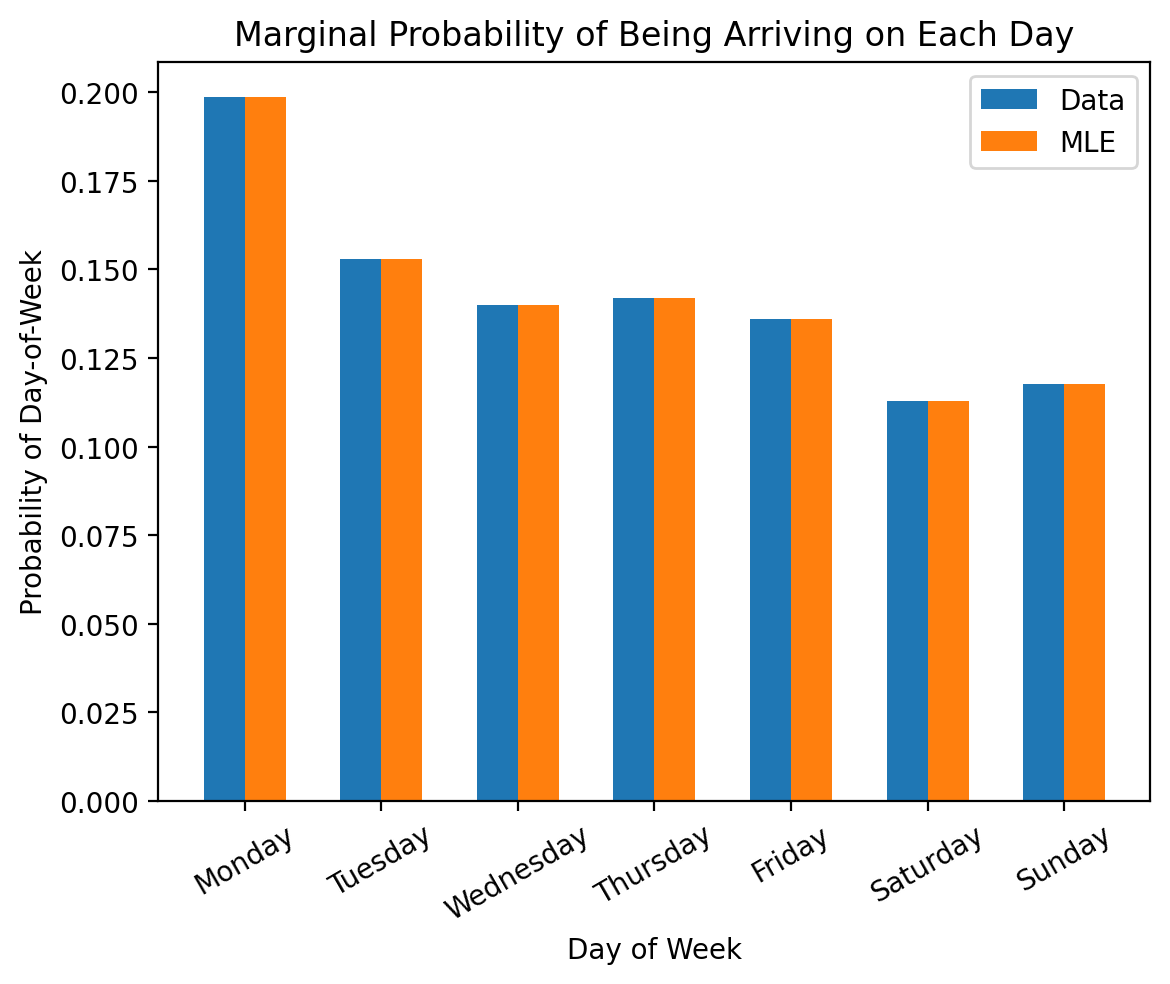

In [11]:
# Plot marginal
width = 0.3
plt.bar(jnp.arange(7) - 0.5 * width, marginal_probabilities_from_data, width, label='Data')
plt.bar(jnp.arange(7) + 0.5 * width, result.parameters_mle['pi'], width, label='MLE')

# Add axis labels and titles
plt.xticks(jnp.arange(7), days_of_week, rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Day-of-Week')
plt.title('Marginal Probability of Being Arriving on Each Day')
plt.legend()
plt.show()

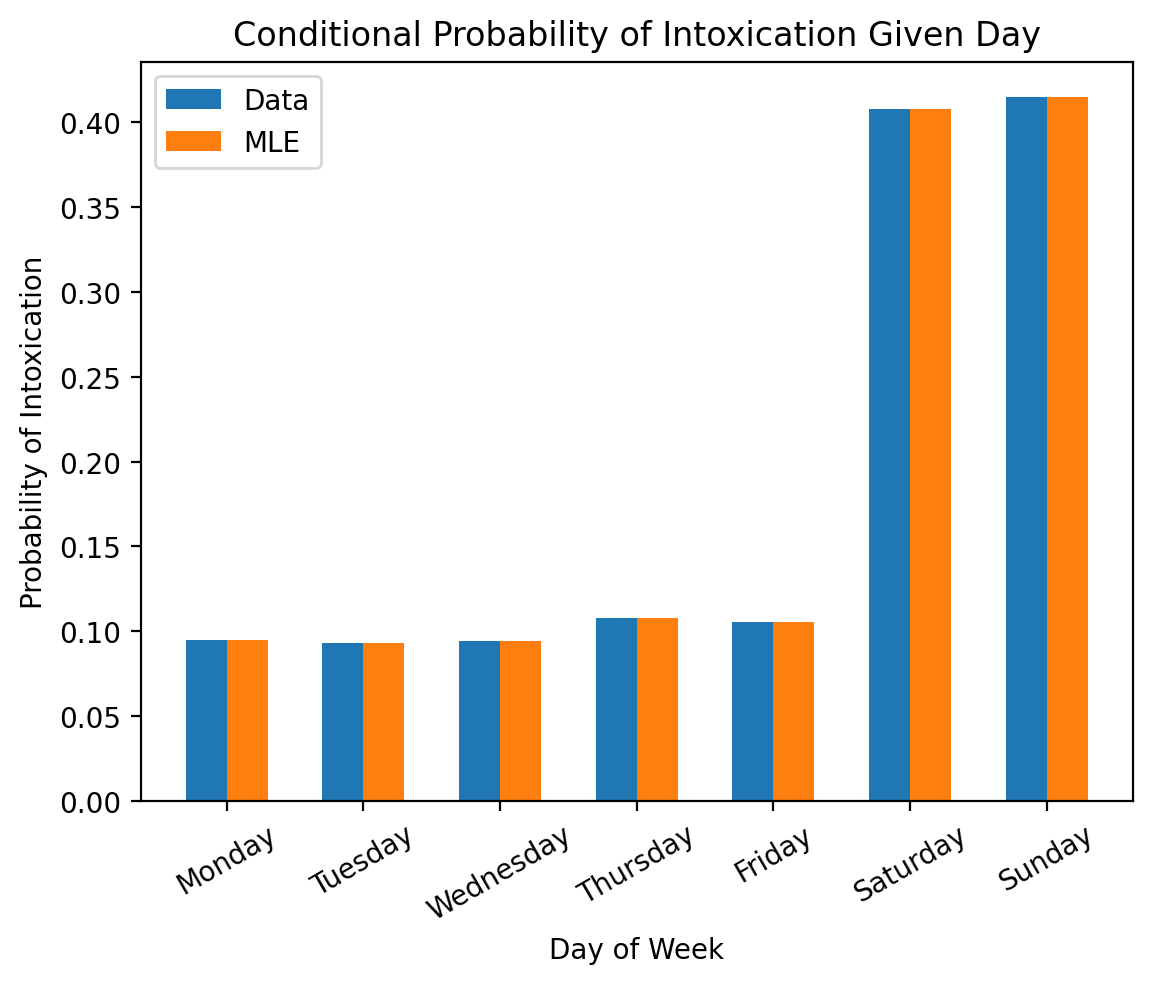

In [12]:
# Plot conditional
width = 0.3
plt.bar(jnp.arange(7) - 0.5 * width, conditional_probabilities_from_data, width, label='Data')
plt.bar(jnp.arange(7) + 0.5 * width, result.parameters_mle['rho'], width, label='MLE')

# Add axis labels and titles
plt.xticks(jnp.arange(7), days_of_week, rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Intoxication')
plt.title('Conditional Probability of Intoxication Given Day')
plt.legend()
plt.show()

**Sampling from the Fitted Model:** We can sample from the fitted model as follows:

In [13]:
N = 20 # Number of samples to generate
key = jrandom.PRNGKey(seed=0) # Random generator key to use
cs349_sample(result.model_mle, key, N)

{'pi': Array([0.19870001, 0.1529    , 0.13990001, 0.1419    , 0.136     ,
        0.113     , 0.11760001], dtype=float32),
 'rho': Array([0.09473917, 0.09301588, 0.09448019, 0.10785804, 0.10519359,
        0.40796468, 0.41496596], dtype=float32),
 'd': Array([4, 2, 3, 4, 6, 4, 4, 5, 3, 1, 5, 1, 2, 1, 4, 0, 2, 0, 0, 4], dtype=int32),
 'i': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1], dtype=int32)}

## Theoretical Properties of the MLE

* Consistency
* Unbiasedness